In [115]:
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as wg
from IPython.display import display

In [170]:
def sort_dict(dict_, reverse=True, values=False, top=None):
    sorted_ = sorted(dict_.items(), key=lambda x: x[1], reverse=reverse)
    if top:
        sorted_ =  sorted_[:top]
    if values:
        return [x[1] for x in sorted_]
    return dict(sorted_)
    

def counter(list_, top = None):
    count_list = Counter(list_)
    if top:
        dict(count_list.most_common(top))
    return count_list

def plot_hist(list_, fig_size=(20,10), ax=None, x_scale='linear', y_scale='linear'):
    if not ax:
        fig, ax = plt.subplots(figsize=fig_size)
    plt_ = sns.histplot(list_, ax=ax)
    plt_.axes.set_xscale(x_scale)
    plt_.axes.set_yscale(y_scale)
    
    

In [38]:
!head -n 5 soc-sign-bitcoinotc.csv

#source,#target,#rating,#timestamp
6,2,4,1289241911.72836
6,5,2,1289241941.53378
1,15,1,1289243140.39049
4,3,7,1289245277.36975


In [332]:
## Is it a multiDiGraph?

G = nx.read_edgelist('soc-sign-bitcoinotc.csv', delimiter=',', nodetype=int,
                     data = (('rating', int), ('time', float)), 
                     create_using=nx.MultiDiGraph)

"""
The maximum number of edges between two nodes is 1, hence the graph is a DiGraph
"""
Counter(G.edges()).most_common(2) 

[((6, 2), 1), ((6, 5), 1)]

In [333]:
G = nx.read_edgelist('soc-sign-bitcoinotc.csv', delimiter=',', nodetype=int,
                     data = (('rating', int), ('time', float)), 
                     create_using=nx.DiGraph)

In [334]:
print("Number of users: ", nx.number_of_nodes(G))
print('NUmber of ratings', nx.number_of_edges(G))

Number of users:  5881
NUmber of ratings 35592


### Plotting a sub graph

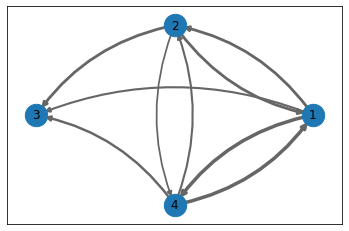

In [337]:
G_sub = nx.subgraph(G, [1,2,3,4])
pos = nx.circular_layout(G_sub)
edge_label = nx.get_edge_attributes(G_sub,'rating')
edge_weight = [0.35*G_sub[u][v]['rating'] for u,v in G_sub.edges()]
nx.draw_networkx_nodes(G_sub, pos, node_size=500)
nx.draw_networkx_labels(G_sub, pos)
_ = nx.draw_networkx_edges(G_sub, pos, connectionstyle='arc3, rad = 0.2', width=edge_weight, edge_color='.4', label=edge_label)
#_ = nx.draw_networkx_edges(G_sub, pos, edge_labels = edge_label, font_size=8)


### Degree centrality distribution
- Most of the users have made fewer transaction and half of the users with less than or equal to 4 transcation

80 percent of users have rated less than 5 users


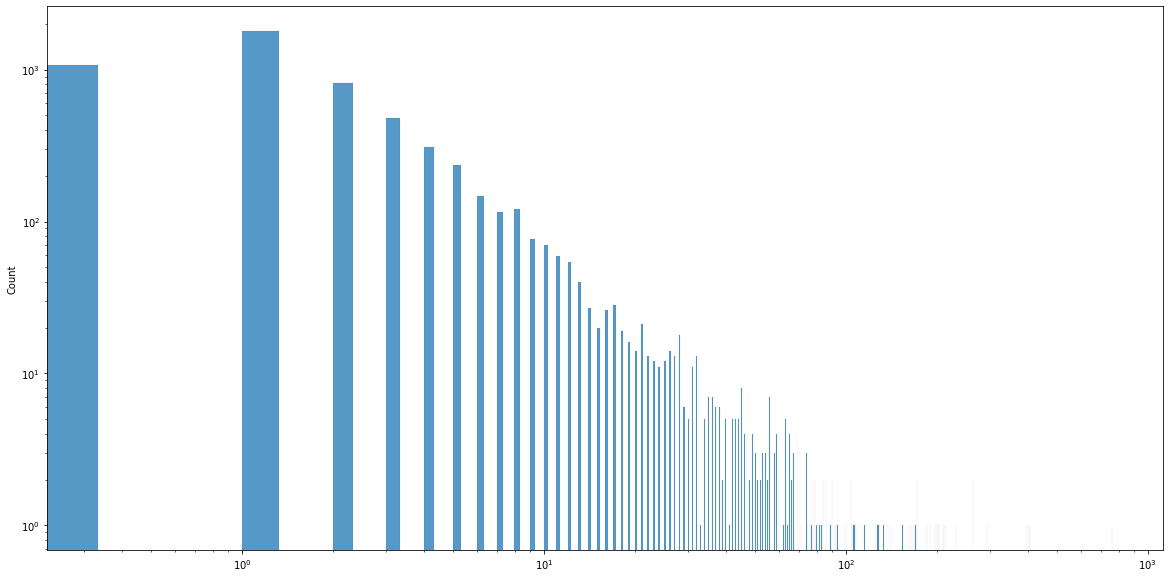

In [317]:
out_degree = dict(G.out_degree())
out_deg_scores = sort_dict(degree, values=True)
print(f'80 percent of users have rated less than {int(np.percentile(out_deg_scores, 80))} users')
plot_hist(out_deg_scores, x_scale='log', y_scale='log')

### 20 percent of users consitute 80 percent of ratings
### 18 percent of users never rated any other users

0.1814317292977385


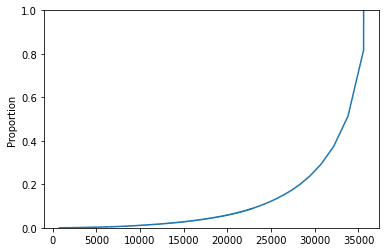

In [331]:
cum_sum_out_deg = np.cumsum(out_deg_scores)
cum_sum_out_deg = cum_sum_out_deg[cum_sum_out_deg>0]
sns.ecdfplot(cum_sum_out_deg)
print(np.mean(np.array(out_deg_scores)==0))

### Rating distribution
- Half of the rating are less than or equal to 1
- Less than 10 percent of ratings are greater than equal to 4

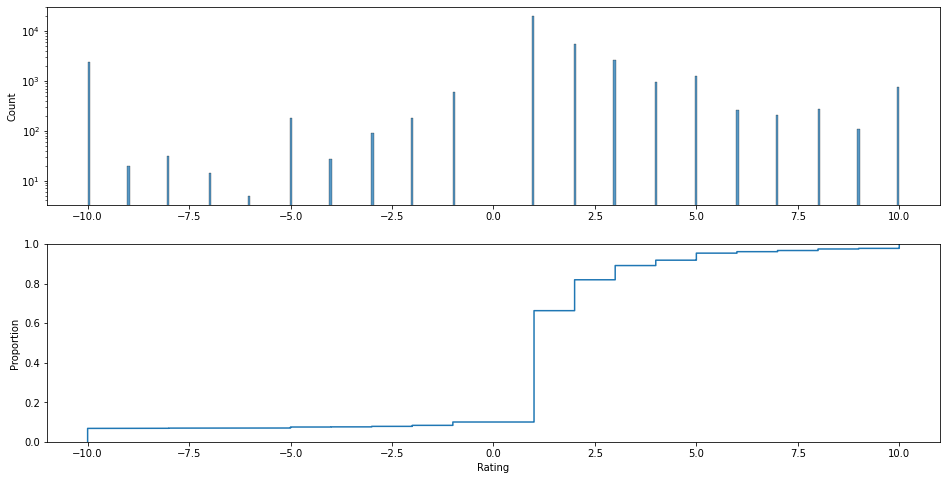

In [182]:
fig, axes = plt.subplots(2,1, figsize=(16,8))
ratings = [G.get_edge_data(*edge)['rating'] for edge in G.edges()]
plot_hist(ratings, fig_size=(10,8), y_scale='log', ax=axes[0])

sns.ecdfplot(ratings, ax=axes[1])
_ = axes[1].set_xlabel('Rating')

### Around 80 percent of users are part of strongly connected component

In [338]:
scc = [node_set for node_set in nx.strongly_connected_components(G)]
scc_count = [len(node_set) for node_set in scc]
scc_node_counter = Counter(scc_count).most_common(5)

print('The number of nodes in largest component is ', scc_node_counter[-1][0])

The number of nodes in largest component is  4709
